In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pyFTS.benchmarks import Measures
import math
from pyFTS.common import Util
import datetime
import statistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pmdarima.arima import auto_arima

## Aux functions

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## Dataset Energy Appliances

In [5]:
dataset = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv')
data = dataset.drop(labels=['date','rv1','rv2'], axis=1)
values = data.values
values

array([[ 60.        ,  30.        ,  19.89      , ...,   7.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      , ...,   6.66666667,
         59.16666667,   5.2       ],
       [ 50.        ,  30.        ,  19.89      , ...,   6.33333333,
         55.33333333,   5.1       ],
       ...,
       [270.        ,  10.        ,  25.5       , ...,   3.66666667,
         25.33333333,  13.26666667],
       [420.        ,  10.        ,  25.5       , ...,   3.83333333,
         26.16666667,  13.23333333],
       [430.        ,  10.        ,  25.5       , ...,   4.        ,
         27.        ,  13.2       ]])

In [6]:
data.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint'],
      dtype='object')

### Dataset Energy Appliances: columns

In [7]:
cols = data.columns
list_cols = list(cols)
list_cols.append('Appliances_t+1')
print(list_cols)

['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'Appliances_t+1']


## Dataset Energy Appliance: Preprocessing, Lag = 1, t+1

In [8]:
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var1(t)
1,0.046729,0.428571,0.32735,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,...,0.661412,0.223032,0.677290,0.372990,0.097674,0.894737,0.500000,0.953846,0.538462,0.046729
2,0.046729,0.428571,0.32735,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,...,0.660155,0.226500,0.678532,0.369239,0.100000,0.894737,0.476190,0.894872,0.533937,0.037383
3,0.037383,0.428571,0.32735,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,...,0.655586,0.219563,0.676049,0.365488,0.102326,0.894737,0.452381,0.835897,0.529412,0.037383
4,0.037383,0.571429,0.32735,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,...,0.650788,0.219563,0.671909,0.361736,0.104651,0.894737,0.428571,0.776923,0.524887,0.046729
5,0.046729,0.571429,0.32735,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,...,0.650788,0.219563,0.671909,0.357985,0.106977,0.894737,0.404762,0.717949,0.520362,0.037383


In [9]:
scaled_data = pd.DataFrame(reframed.values,columns=list_cols)
scaled_data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Appliances_t+1
0,0.046729,0.428571,0.32735,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,...,0.661412,0.223032,0.677290,0.372990,0.097674,0.894737,0.500000,0.953846,0.538462,0.046729
1,0.046729,0.428571,0.32735,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,...,0.660155,0.226500,0.678532,0.369239,0.100000,0.894737,0.476190,0.894872,0.533937,0.037383
2,0.037383,0.428571,0.32735,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,...,0.655586,0.219563,0.676049,0.365488,0.102326,0.894737,0.452381,0.835897,0.529412,0.037383
3,0.037383,0.571429,0.32735,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,...,0.650788,0.219563,0.671909,0.361736,0.104651,0.894737,0.428571,0.776923,0.524887,0.046729
4,0.046729,0.571429,0.32735,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,...,0.650788,0.219563,0.671909,0.357985,0.106977,0.894737,0.404762,0.717949,0.520362,0.037383


## Model: SARIMAX

### Define SARIMAX parameters

In [22]:
values = reframed.values
train_size=int(len(values)*0.75)
test_size = int(len(values)) - train_size
print(test_size)

4934


In [23]:
# split into train and test sets
train_X, train_y = values[:train_size], values[:train_size]
test_X, test_y = values[train_size:], values[train_size:]

# split into input (all columns exceptc last one) and outputs (last column)
train_X, train_y = train_X[:, :-1], train_y[:, -1]
test_X, test_y = test_X[:, :-1], test_y[:, -1]

# reshape input to be 3D [samples, timesteps, features]; each line turns into an 'sub-array'
train_X = train_X.reshape((train_X.shape[0],train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14800, 26) (14800,) (4934, 26) (4934,)


In [12]:
# from pmdarima.arima import auto_arima
# step_wise=auto_arima(train_y, 
#  exogenous= train_X,
#  start_p=1, start_q=1, 
#  max_p=3, max_q=3, 
#  d=1, max_d=3,
#  trace=True, 
#  error_action='ignore', 
#  suppress_warnings=True, 
#  stepwise=True,
#  seasonal=True)

In [13]:
# sarimax_model = auto_arima(train_y,
#                        exogenous= train_X,
#                        start_p=1,
#                        start_q=1,
#                        max_p=3,
#                        max_q=3,
#                        m=12,
#                        seasonal=True,
#                        d=None,
#                        D=1,
#                        trace=True,
#                        error_action='ignore',
#                        suppress_warnings=True,
#                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-25066.330, Time=349.47 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-19612.679, Time=24.71 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-22234.220, Time=327.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-25066.736, Time=323.97 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-19614.679, Time=93.30 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-19815.054, Time=158.00 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-25082.732, Time=377.95 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-22262.687, Time=295.60 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=-24854.196, Time=473.62 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=562.10 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-25218.669, Time=519.57 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=-25068.679, Time=1090.48 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-25091.734, Time=583.06 sec
 ARIMA(0,0,2)(0,1,2)[12] intercept   : AIC

In [24]:
# Best model:  ARIMA(0,0,1)(0,1,2)[12] intercept
# Total fit time: 11753.701 seconds
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 9867
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood               12640.334
Date:                                 Sat, 19 Jun 2021   AIC                         -25218.669
Time:                                         22:08:41   BIC                         -24995.601
Sample:                                              0   HQIC                        -25143.107
                                                - 9867                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.011e-05      0.000      0.409      0.682      -0.000       0.000
x1             0.5925      0.008     78.424      0.000       0.578       0.607
x2             0.0533      0.006      9.497      0.000       0.042       0.064
x3            -0.1430      0.027     -5.312      0.000      -0.196      -0.090
x4             0.0194      0.021      0.933      0.351      -0.021       0.060
x5             0.0647      0.034      1.878      0.060      -0.003       0.132
x6            -0.0828      0.032     -2.579      0.010      -0.146      -0.020
x7             0.0898      0.018      4.862      0.000       0.054       0.126
x8             0.0790      0.020      3.889      0.000       0.039       0.119
x9            -0.0368      0.013     -2.794      0.005      -0.063      -0.011
x10            0.0272      0.022      1.257      0.209      -0.015       0.070
x11           -0.0289      0.018     -1.635      0.102      -0.064       0.006
x12            0.0013      0.008      0.171      0.864      -0.014       0.017
x13            0.0273      0.043      0.641      0.521      -0.056       0.111
x14            0.0100      0.013      0.773      0.440      -0.015       0.036
x15           -0.0032      0.025     -0.128      0.898      -0.053       0.046
x16           -0.0344      0.020     -1.723      0.085      -0.074       0.005
x17           -0.0292      0.017     -1.693      0.091      -0.063       0.005
x18           -0.0773      0.021     -3.605      0.000      -0.119      -0.035
x19            0.0680      0.053      1.296      0.195      -0.035       0.171
x20           -0.0037      0.018     -0.207      0.836      -0.039       0.031
x21           -0.2675      0.143     -1.869      0.062      -0.548       0.013
x22           -0.0175      0.011     -1.621      0.105      -0.039       0.004
x23           -0.1281      0.062     -2.082      0.037      -0.249      -0.007
x24            0.0095      0.008      1.167      0.243      -0.006       0.025
x25            0.0058      0.005      1.268      0.205      -0.003       0.015
x26            0.2530      0.098      2.578      0.010       0.061       0.445
ma.L1          0.2212      0.008     29.403      0.000       0.206       0.236
ma.S.L12      -0.8340      0.007   -123.051      0.000      -0.847      -0.821
ma.S.L24      -0.0386      0.008     -4.783      0.000      -0.054      -0.023
sigma2         0.0045   2.96e-05    151.914      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   1.69   Jarque-Bera (JB):            111901.89
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             2.43
Prob(H) (two-sided):                  0.00   Kurtosis:            

In [15]:
## order=(3, 1, 2) ==> parameters already used 

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
 exog=train_X,
 order=(0,0,1),
 seasonal_order=(0,1,2,12),
 enforce_invertibility=False, 
 enforce_stationarity=False)

In [26]:
results = model.fit()

/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                14800
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood               19578.187
Date:                                 Sat, 19 Jun 2021   AIC                         -39096.374
Time:                                         22:23:41   BIC                         -38868.380
Sample:                                              0   HQIC                        -39020.669
                                               - 14800                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6296      0.006    112.055      0.000       0.619       0.641
x2             0.0491      0.005     10.561      0.000       0.040       0.058
x3            -0.0966      0.017     -5.770      0.000      -0.129      -0.064
x4             0.0225      0.016      1.371      0.170      -0.010       0.055
x5             0.0725      0.024      3.026      0.002       0.026       0.119
x6            -0.0036      0.024     -0.153      0.879      -0.050       0.043
x7             0.1100      0.010     11.025      0.000       0.090       0.130
x8             0.0186      0.014      1.351      0.177      -0.008       0.046
x9            -0.0208      0.010     -2.085      0.037      -0.040      -0.001
x10           -0.0104      0.015     -0.700      0.484      -0.039       0.019
x11           -0.0221      0.012     -1.830      0.067      -0.046       0.002
x12           -0.0093      0.006     -1.614      0.106      -0.021       0.002
x13            0.0336      0.028      1.198      0.231      -0.021       0.089
x14            0.0145      0.007      2.101      0.036       0.001       0.028
x15            0.0112      0.013      0.845      0.398      -0.015       0.037
x16           -0.0031      0.013     -0.234      0.815      -0.029       0.023
x17            0.0369      0.010      3.754      0.000       0.018       0.056
x18           -0.0494      0.013     -3.789      0.000      -0.075      -0.024
x19           -0.0433      0.018     -2.453      0.014      -0.078      -0.009
x20            0.0007      0.010      0.067      0.946      -0.020       0.021
x21            0.0418      0.072      0.584      0.559      -0.099       0.182
x22           -0.0005      0.004     -0.106      0.916      -0.009       0.008
x23            0.0241      0.033      0.724      0.469      -0.041       0.089
x24            0.0084      0.005      1.777      0.076      -0.001       0.018
x25            0.0011      0.004      0.268      0.788      -0.007       0.009
x26           -0.0425      0.051     -0.841      0.400      -0.142       0.057
ma.L1          0.1773      0.006     29.253      0.000       0.165       0.189
ma.S.L12      -0.9648      0.006   -167.567      0.000      -0.976      -0.953
ma.S.L24      -0.0371      0.006     -6.715      0.000      -0.048      -0.026
sigma2         0.0041   1.98e-05    207.830      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   1.14   Jarque-Bera (JB):            301095.45
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             3.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.25
=============================================================

In [30]:
steps = -1
yhat = results.predict(start=train_size, end=train_size+test_size+(steps),exog=test_X)
yhat

array([0.21387824, 0.20101813, 0.23810919, ..., 0.08568906, 0.19443359,
       0.27580251])

In [33]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat.reshape(len(yhat),1), test_X[:, 1:]), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual - observed data
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

(4934, 26)


In [34]:
rmse = Measures.rmse(inv_yhat,inv_y)
mape = Measures.mape(inv_yhat,inv_y)
smape = Measures.smape(inv_yhat,inv_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test SMAPE: %.3f' % smape)

Test RMSE: 60.819
Test MAPE: 27.963
Test SMAPE: 13.529


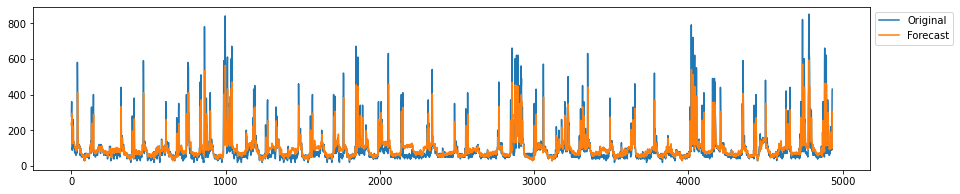

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
ax.plot(inv_y, label='Original')
ax.plot(inv_yhat, label='Forecast')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

## Model: SARIMAX - Final model

In [44]:
def train_sarimax(endog, exog, order, seasonal_order):
    model=sm.tsa.SARIMAX(endog = endog, exog = exog, 
                         order=(0,0,1),
                         seasonal_order=(0,1,2,12), 
                         enforce_invertibility=False, 
                         enforce_stationarity=False)
    sarimax = model.fit()
    return sarimax


def test_sarimax(model,start,end,exog):
    forecasts = model.predict(start=start, end=end, exog=exog)
    return forecasts
    

In [45]:
def transform_original(test_X,test_y,yhat):
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat.reshape(len(yhat),1), test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual - observed data
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
    ax.plot(inv_y, label='Original')
    ax.plot(inv_yhat, label='Forecast')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
    plt.show()
    
    return inv_y,inv_yhat

## Sliding Window PyFTS: SARIMAX

--------------------
training window 0


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:33:55] getting statistics


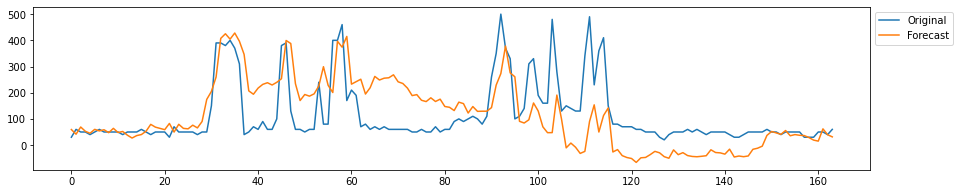

--------------------
training window 657


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:34:34] getting statistics


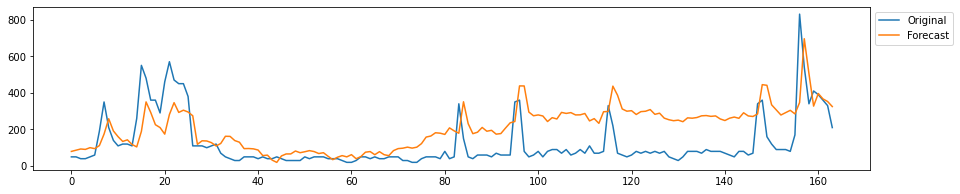

--------------------
training window 1314


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:35:21] getting statistics


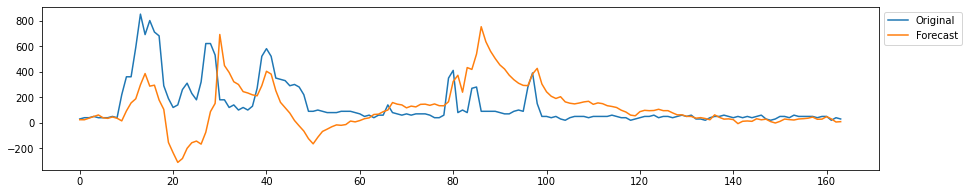

--------------------
training window 1971


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:36:06] getting statistics


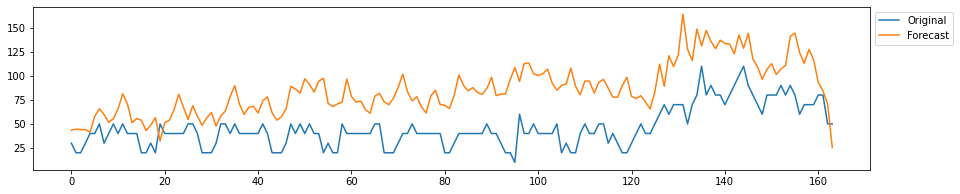

--------------------
training window 2628


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:36:49] getting statistics


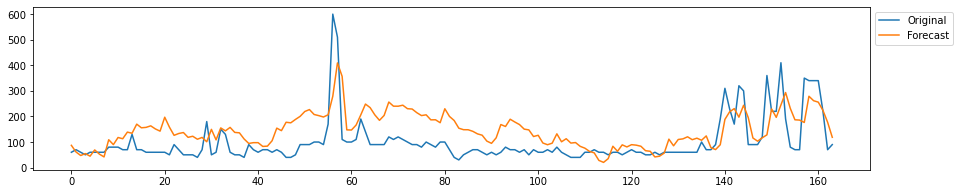

--------------------
training window 3285


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:37:29] getting statistics


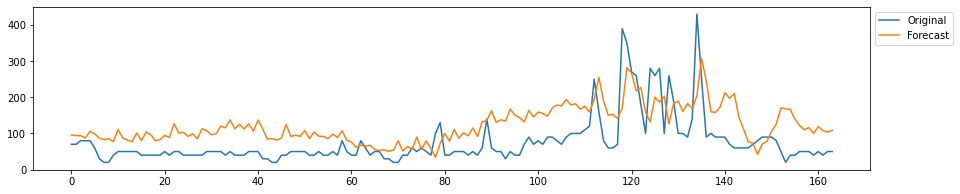

--------------------
training window 3942


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:38:11] getting statistics


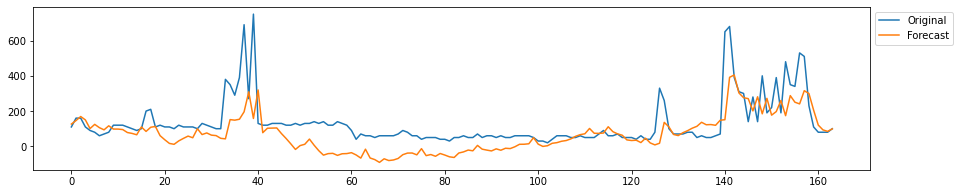

--------------------
training window 4599


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:38:55] getting statistics


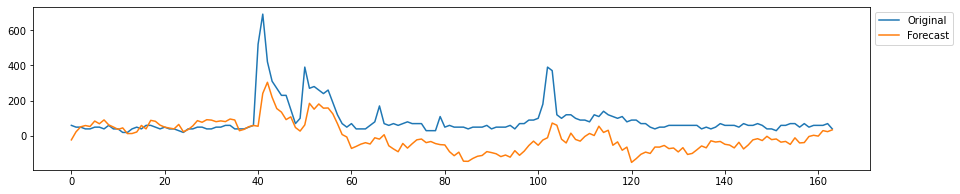

--------------------
training window 5256


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:39:37] getting statistics


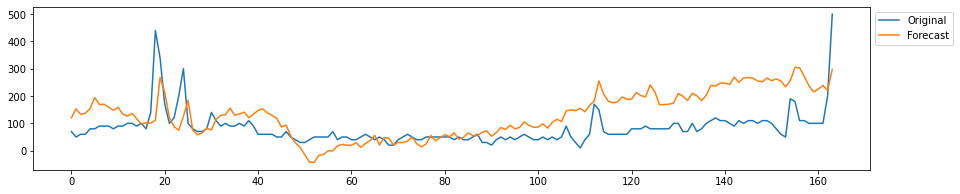

--------------------
training window 5913


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:40:17] getting statistics


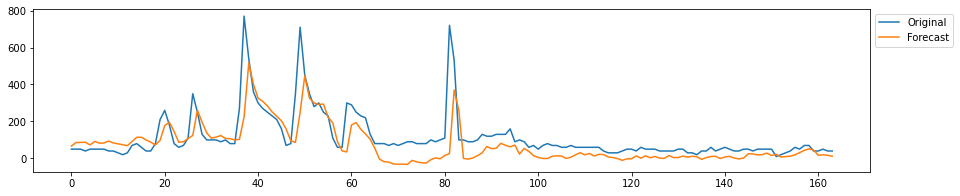

--------------------
training window 6570


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:40:57] getting statistics


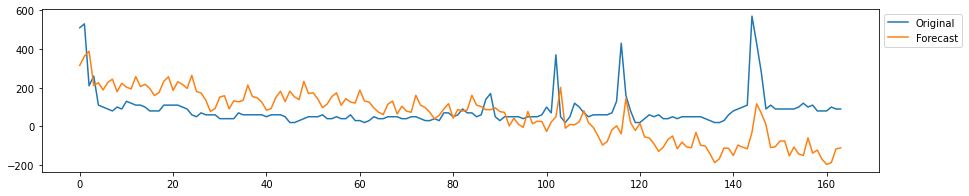

--------------------
training window 7227


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:41:39] getting statistics


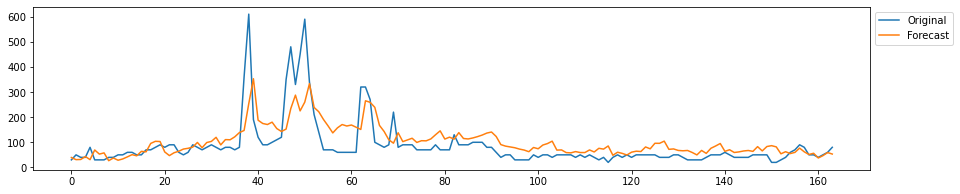

--------------------
training window 7884


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:42:21] getting statistics


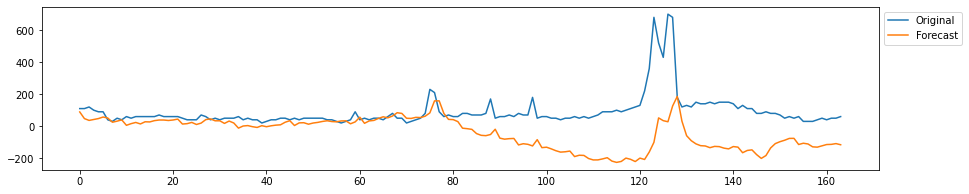

--------------------
training window 8541


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:43:00] getting statistics


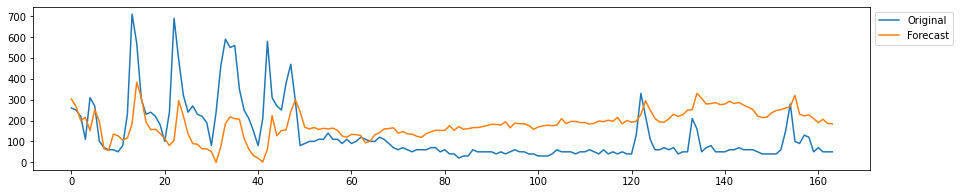

--------------------
training window 9198


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:43:38] getting statistics


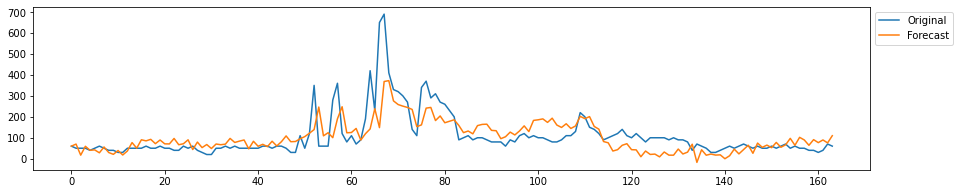

--------------------
training window 9855


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:44:18] getting statistics


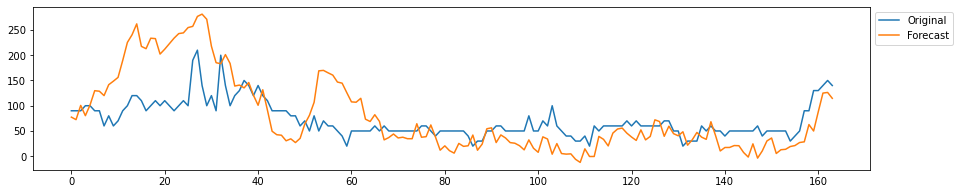

--------------------
training window 10512


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:44:57] getting statistics


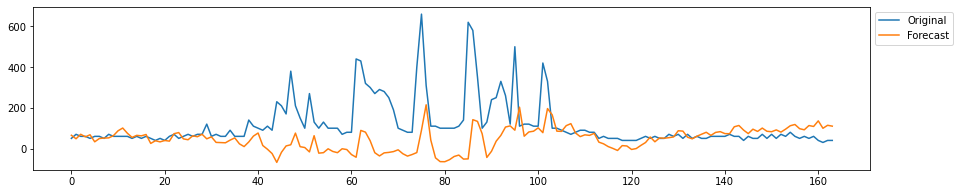

--------------------
training window 11169


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:45:37] getting statistics


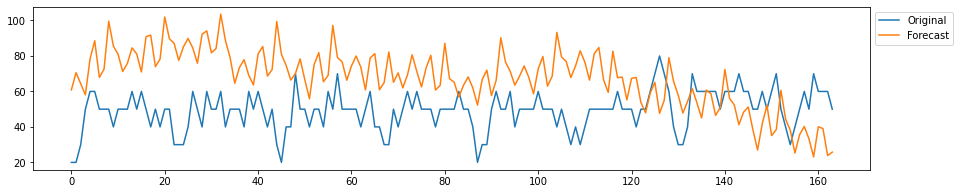

--------------------
training window 11826


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:46:20] getting statistics


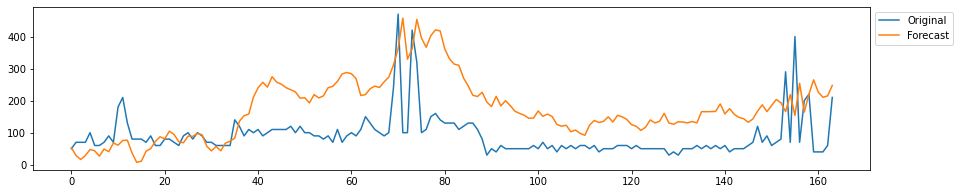

--------------------
training window 12483


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:47:01] getting statistics


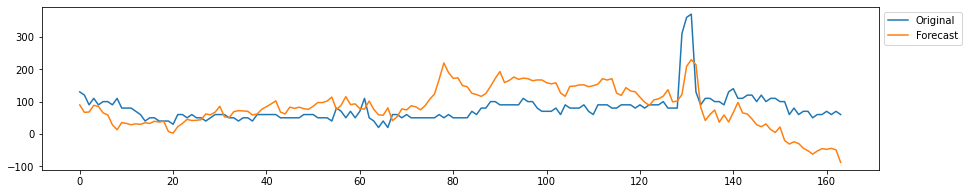

--------------------
training window 13140


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:47:42] getting statistics


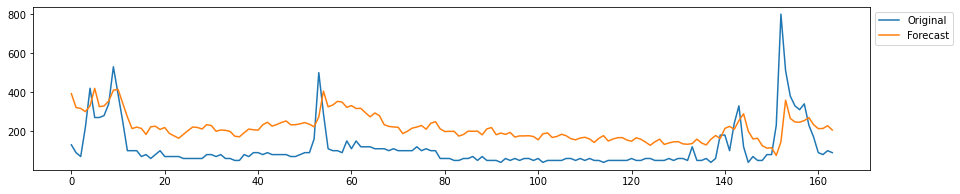

--------------------
training window 13797


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:48:22] getting statistics


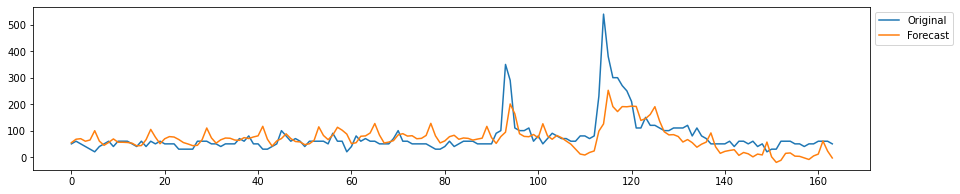

--------------------
training window 14454


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:48:58] getting statistics


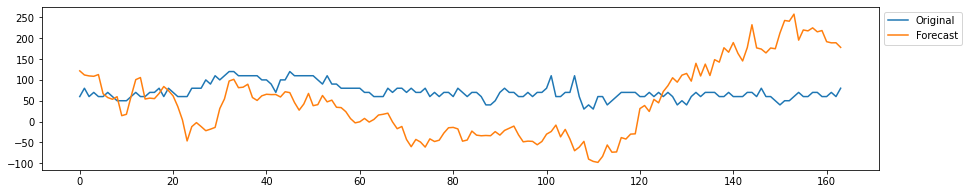

--------------------
training window 15111


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:49:37] getting statistics


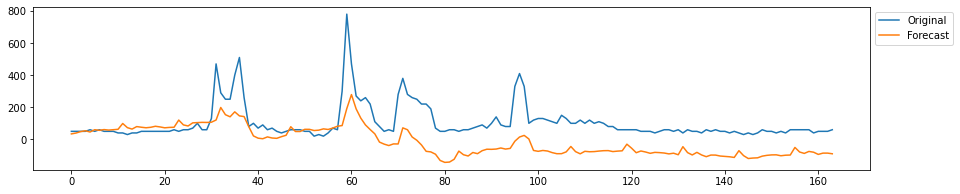

--------------------
training window 15768


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:50:15] getting statistics


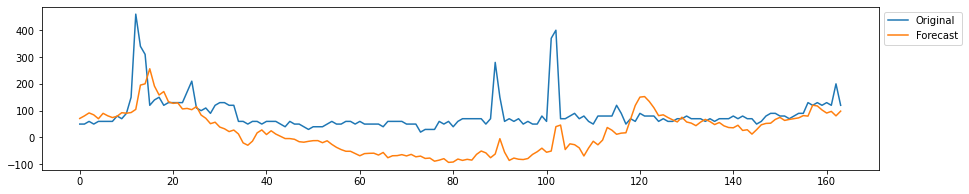

--------------------
training window 16425


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:50:59] getting statistics


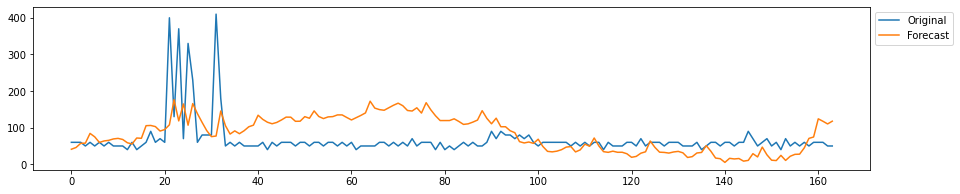

--------------------
training window 17082


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:51:48] getting statistics


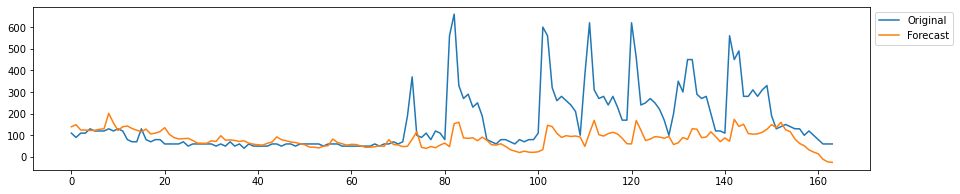

--------------------
training window 17739


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:52:32] getting statistics


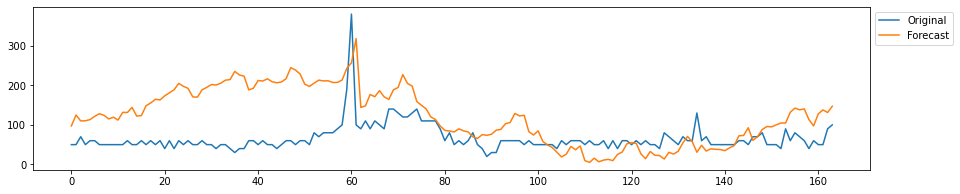

--------------------
training window 18396


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:53:20] getting statistics


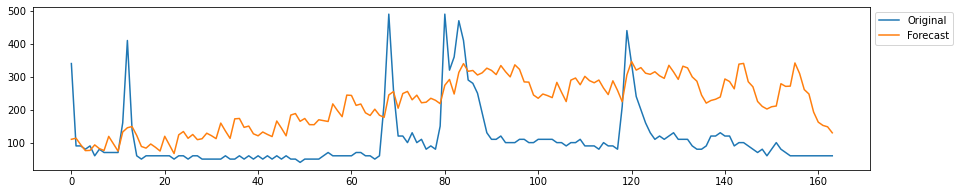

--------------------
training window 19053


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 22:54:03] getting statistics


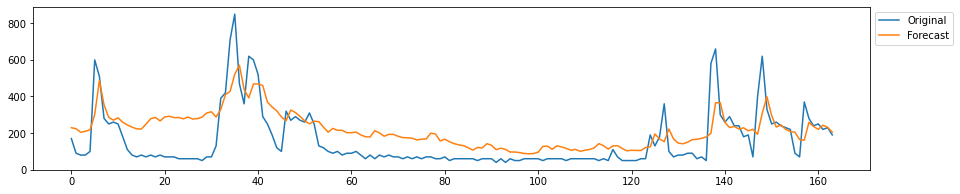

In [46]:
result = {
     "window": [],
     "rmse": [],
     "mape": [],
     "smape": []
}

tam = len(scaled_data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(scaled_data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        
        start = len(ttrain)
        end = len(ttrain)+ len(ttest) -1
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model = train_sarimax(ttrain.loc[:,'Appliances_t+1'], ttrain.loc[:,'Appliances':'Tdewpoint'], [0,0,1], [0,1,2,12])
        yhat = test_sarimax(model, start, end, ttest.loc[:,'Appliances':'Tdewpoint']) 
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")

        test_X = ttest.loc[:,'Appliances':'Tdewpoint'].values
        test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
        test_y = ttest['Appliances_t+1']
        appliances,forecast = transform_original(test_X,test_y.values,yhat.values)
        
        rmse = Measures.rmse(appliances,forecast)
        mape = Measures.mape(appliances,forecast)
        smape = Measures.smape(appliances,forecast)
                
        result["rmse"].append(rmse)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["window"].append(ct)

measures = pd.DataFrame(result)


In [48]:
measures

,window,rmse,mape,smape
0,0,121.090569,116.539494,45.808617
1,657,153.438646,172.084892,39.672408
2,1314,215.104928,135.280038,46.495375
3,1971,44.085432,113.515708,31.837299
4,2628,87.351591,91.898048,28.654078
5,3285,71.846656,113.733712,33.021995
6,3942,123.868605,80.609745,48.310822
7,4599,125.221965,137.809923,70.068206
8,5256,91.943869,104.890613,34.029001
9,5913,102.423359,68.947459,48.034437


### Mean Statistics SARIMAX

In [49]:
final_result = {
     "rmse": [],
     "mape": [],
     "smape": []
}

final_result["rmse"].append(statistics.mean(measures['rmse']))
final_result["mape"].append(statistics.mean(measures['mape']))
final_result["smape"].append(statistics.mean(measures['smape']))
        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics SARIMAX (test): ")
final_measures_pca

Mean Statistics SARIMAX (test): 


,rmse,mape,smape
0,110.432878,109.917189,41.307414
